In [1]:
import numpy as np
import pandas as pd
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import albumentations as A
# import segmentation_models_pytorch as smp
# import segmentation_models_pytorch.utils as smpu
import seaborn as sns
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from glob import glob
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
print("ok")

ok


In [2]:
width = 128
height = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transforms = T.Compose([
    T.Resize((width, height)),
])

In [4]:
train_images = sorted(glob("../input/lung-mask-image-dataset/ChestXray/train/image/*.png"))
train_masks = sorted(glob("../input/lung-mask-image-dataset/ChestXray/train/mask/*.jpeg"))

val_images = sorted(glob("../input/lung-mask-image-dataset/ChestXray/val/image/*.png"))
val_masks = sorted(glob("../input/lung-mask-image-dataset/ChestXray/val/mask/*.jpeg"))

test_images = sorted(glob("../input/lung-mask-image-dataset/ChestXray/test/image/*.png"))
test_masks = sorted(glob("../input/lung-mask-image-dataset/ChestXray/test/mask/*.jpeg"))

In [5]:
class MyDataset(Dataset):
    def __init__(self,root ,images, masks, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms
        
        self.images = images
        self.mask = masks
        self.root = root
        
    def __getitem__(self, index: int):
                
        image = Image.open(self.images[index]).convert('L')
        mask = Image.open(self.mask[index]).convert('L')
        
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        t = T.Compose([
            T.Resize((width, height)),
            T.ToTensor(),

        ])

        image = t(image)
        mask = T.ToTensor()(np.array(mask))
        
        return image, mask
    
    def __len__(self):
        return len(self.images)

In [6]:
import random

i = random.randint(0,len(train_images)-1)
sample_img = np.asarray(Image.open(train_images[i]))
sample_mask = np.asarray(Image.open(os.path.join(train_masks[i])))
print(sample_img.shape, sample_mask.shape)

(512, 512, 4) (512, 512, 3)


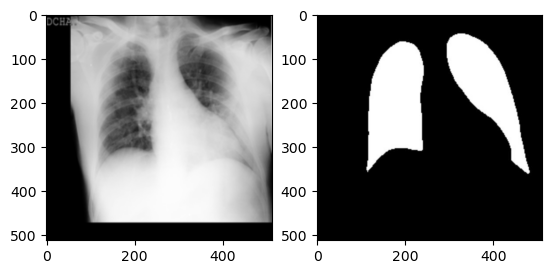

In [7]:
plt.subplot(1,2,1)
plt.imshow(sample_img[:,:,:3])

plt.subplot(1,2,2)
plt.imshow(sample_mask)

plt.show()

In [8]:
train_dataset = MyDataset("../input/lung-mask-image-dataset/ChestXray/train/",train_images, train_masks,
                                 train=True,
                                 transforms=transforms)

val_dataset = MyDataset("../input/lung-mask-image-dataset/ChestXray/val/",val_images, val_masks,
                                train=False,
                                transforms=transforms)

test_dataset = MyDataset("../input/lung-mask-image-dataset/ChestXray/test/",test_images, test_masks,
                                train=False,
                                transforms=transforms)

In [9]:
train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=8,
                                 shuffle=True,
                                 pin_memory=True,
                                 num_workers=0)

val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=8,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=0)

In [10]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smpu

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    in_channels = 1
)

In [11]:
train_logs_list = []
valid_logs_list = []   
def prepare_train(model, loss, metrics, DEVICE, train_loader, valid_loader):
 
    optimizer = torch.optim.Adam([ 
      dict(params=model.parameters(), lr=0.001),
    ])

    train_epoch = smp.utils.train.TrainEpoch(
      model, 
      loss=loss, 
      metrics=metrics, 
      optimizer=optimizer,
      device=DEVICE,
      verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
      model, 
      loss=loss, 
      metrics=metrics, 
      device=DEVICE,
      verbose=True,
    )
    max_score = 0

    for i in range(0, 10):
    
        print('\nEpoch: {}'.format(i))
        train_logs_list.append(train_epoch.run(train_loader))
        valid_logs = valid_epoch.run(valid_loader)
        valid_logs_list.append(valid_logs)
    # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, 'MyModel+changeOptim.pth')
            print('Model saved!')
        
        if i == 8:
            optimizer.param_groups[0]['lr'] = 1e-4
            print('Decrease decoder learning rate to 1e-4!')
            

In [12]:
loss = smpu.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [13]:
prepare_train(model, loss, metrics, device, train_loader=train_dataset_loader,
              valid_loader = val_dataset_loader)


Epoch: 0
valid: 100%|██████████| 265/265 [00:30<00:00,  8.69it/s, dice_loss - 0.04772, iou_score - 0.9108]
Model saved!

Epoch: 1
valid: 100%|██████████| 265/265 [00:30<00:00,  8.58it/s, dice_loss - 0.05829, iou_score - 0.8916]

Epoch: 2
valid: 100%|██████████| 265/265 [00:30<00:00,  8.62it/s, dice_loss - 0.04687, iou_score - 0.9116]
Model saved!

Epoch: 3
valid: 100%|██████████| 265/265 [00:30<00:00,  8.56it/s, dice_loss - 0.04794, iou_score - 0.9093]

Epoch: 4
valid: 100%|██████████| 265/265 [00:30<00:00,  8.57it/s, dice_loss - 0.0467, iou_score - 0.9115] 

Epoch: 5
valid: 100%|██████████| 265/265 [00:30<00:00,  8.61it/s, dice_loss - 0.04163, iou_score - 0.9206]
Model saved!

Epoch: 6
valid: 100%|██████████| 265/265 [00:31<00:00,  8.50it/s, dice_loss - 0.07913, iou_score - 0.8543]

Epoch: 7
valid: 100%|██████████| 265/265 [00:31<00:00,  8.48it/s, dice_loss - 0.03974, iou_score - 0.924] 
Model saved!

Epoch: 8
valid: 100%|██████████| 265/265 [00:30<00:00,  8.72it/s, dice_loss - 0.044

In [31]:
test_dataset_loader = DataLoader(dataset=test_dataset,
                                batch_size=4,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=0)

In [38]:
import cv2
def merge(pred, sample):


    
    x = pred
    x = x.detach().numpy()
    x = np.repeat(x, 3, axis=0)
    threshold = 0.5

    x = np.where(x > threshold, 0, 1)
    x = x.reshape(3,128,128)
    x = torch.from_numpy(x)
    
    y = sample    
    z = x * y

    return z

def plot_pred_img(samples, pred):

    segment = []

    for i in range(0,4):
        x = pred[i][:][:][:].clone()
        y = samples[0][i]
        segment.append(merge(x, y))


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('Input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples[0], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('Input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples[1], padding=2).numpy(),
                           (1, 2, 0)))
    
    ax3.axis('off')
    ax3.set_title('Predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).numpy(),
                           (1, 2, 0)))
    
    ax4.axis('off')
    ax4.set_title('Segmented')
    ax4.imshow(np.transpose(vutils.make_grid(segment, padding=2).numpy(),
                           (1, 2, 0)))

100%|██████████| 529/529 [00:31<00:00, 16.90it/s]


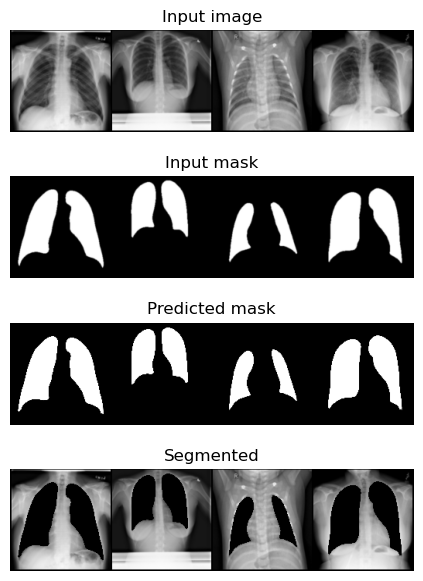

In [39]:
for idx, data in enumerate(tqdm(test_dataset_loader)):
    train_img = data[0].to(device)
    train_mask = data[1].type(torch.float).to(device)
    train_output_mask = model(train_img)
plot_pred_img(data, train_output_mask.cpu())

In [40]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataset_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 529/529 [00:33<00:00, 15.89it/s, dice_loss - 0.02261, iou_score - 0.9559]
Evaluation on Test Data: 
Mean IoU Score: 0.9559
Mean Dice Loss: 0.0226


In [41]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.045182,0.034147,0.032654,0.031442,0.030213,0.030214,0.029212,0.028718,0.028733,0.026693
iou_score,0.921698,0.935087,0.937456,0.939529,0.941707,0.941668,0.943502,0.944391,0.944364,0.948184


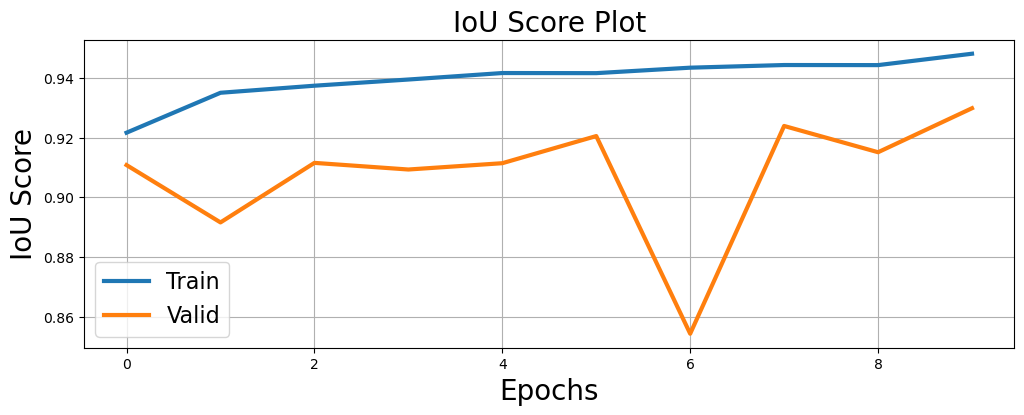

In [49]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

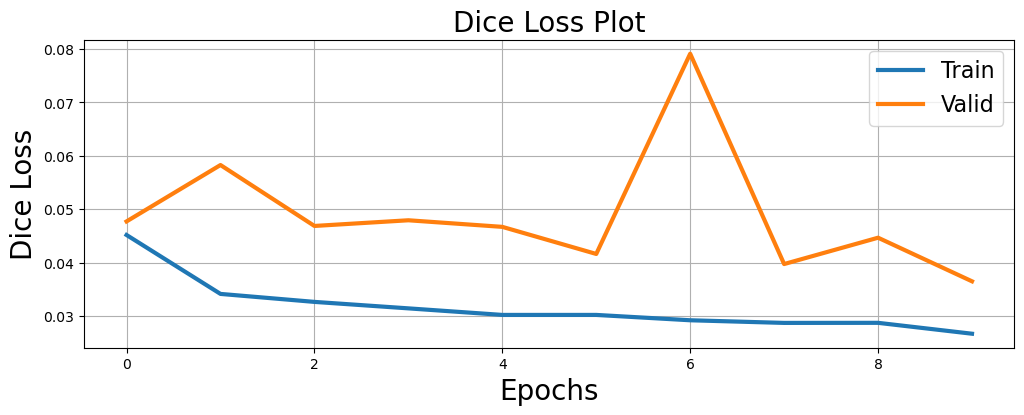

In [50]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()